In [29]:
import dgl
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
import espaloma as esp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
! git pull

Already up to date.


In [74]:
g = esp.Graph('C')

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [75]:
forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

In [76]:
from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

In [77]:
g.heterograph.nodes['n1'].data['xyz'].mean(dim=1)

tensor([[ 0.4724,  0.1898, -0.1617],
        [ 0.4772,  0.2092, -0.1397],
        [ 0.5114,  0.2144, -0.1233],
        [ 0.4302,  0.1503, -0.2219],
        [ 0.4711,  0.1849, -0.1623]], grad_fn=<MeanBackward1>)

In [78]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [79]:
states = []
losses = []

In [88]:
for name, param in net.named_parameters():
    print(name)
    print(param)

0.n1_epsilon
Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
0.n1_sigma
Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
0.n2_k
Parameter containing:
tensor([[-0.0975],
        [-0.5351],
        [-0.0865],
        [-0.3002],
        [-0.0975],
        [-0.5351],
        [-0.0865],
        [-0.3002]], requires_grad=True)
0.n2_eq
Parameter containing:
tensor([[0.8993],
        [0.7635],
        [0.9389],
        [0.9662],
        [0.8993],
        [0.7635],
        [0.9389],
        [0.9662]], requires_grad=True)
0.n3_k
Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
0.n3_eq
Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
       

In [80]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        states.append(
            {
                '%s_%s' % (term, param): getattr(
                    net[0],
                    '%s_%s' % (term, param)
                ).detach().numpy()
                for term in ['n2'] for param in ['k', 'eq']
            }
        )
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)

tensor(3.0642, grad_fn=<SumBackward0>)
tensor(2.9334, grad_fn=<SumBackward0>)
tensor(2.7730, grad_fn=<SumBackward0>)
tensor(2.5882, grad_fn=<SumBackward0>)
tensor(2.3997, grad_fn=<SumBackward0>)
tensor(2.2423, grad_fn=<SumBackward0>)
tensor(2.1819, grad_fn=<SumBackward0>)
tensor(2.3145, grad_fn=<SumBackward0>)
tensor(2.3830, grad_fn=<SumBackward0>)
tensor(2.3038, grad_fn=<SumBackward0>)
tensor(2.2110, grad_fn=<SumBackward0>)
tensor(2.1706, grad_fn=<SumBackward0>)
tensor(2.1779, grad_fn=<SumBackward0>)
tensor(2.2060, grad_fn=<SumBackward0>)
tensor(2.2333, grad_fn=<SumBackward0>)
tensor(2.2495, grad_fn=<SumBackward0>)
tensor(2.2516, grad_fn=<SumBackward0>)
tensor(2.2413, grad_fn=<SumBackward0>)
tensor(2.2221, grad_fn=<SumBackward0>)
tensor(2.1992, grad_fn=<SumBackward0>)
tensor(2.1784, grad_fn=<SumBackward0>)
tensor(2.1665, grad_fn=<SumBackward0>)
tensor(2.1683, grad_fn=<SumBackward0>)
tensor(2.1818, grad_fn=<SumBackward0>)
tensor(2.1960, grad_fn=<SumBackward0>)
tensor(2.1991, grad_fn=<S

tensor(2.1629, grad_fn=<SumBackward0>)
tensor(2.1629, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<SumBackward0>)
tensor(2.1628, grad_fn=<S

tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<SumBackward0>)
tensor(2.1626, grad_fn=<S

tensor(2.1624, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<SumBackward0>)
tensor(2.1623, grad_fn=<S

tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1621, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<SumBackward0>)
tensor(2.1620, grad_fn=<S

In [83]:
eqs

array([[0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415],
       [0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415],
       [0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415],
       ...,
       [0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415],
       [0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415],
       [0.58538085, 0.6425807 , 0.8756483 , ..., 0.6425807 , 0.8756483 ,
        0.57508415]], dtype=float32)

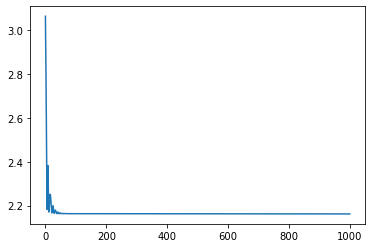

In [81]:
plt.plot(losses)

In [69]:
ks = np.array([state['n2_k'].flatten() for state in states])
eqs = np.array([state['n2_eq'].flatten() for state in states])

In [87]:
eqs.std(axis=0)

array([5.6028366e-06, 2.2649765e-06, 6.3180923e-06, 5.4240227e-06,
       5.6028366e-06, 2.2649765e-06, 6.3180923e-06, 5.4240227e-06],
      dtype=float32)

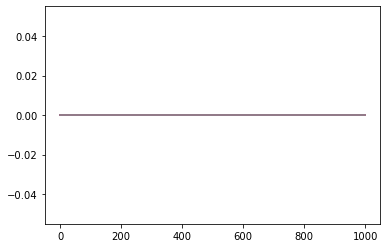

In [73]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

ValueError: only one element tensors can be converted to Python scalars

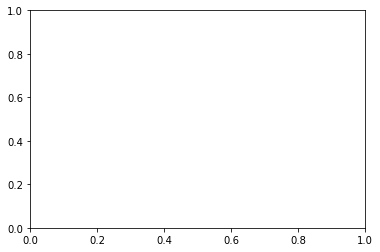

In [55]:
plt.plot(ks, label='k')
plt.plot(eqs, label='eq')

Text(0, 0.5, 'pred')

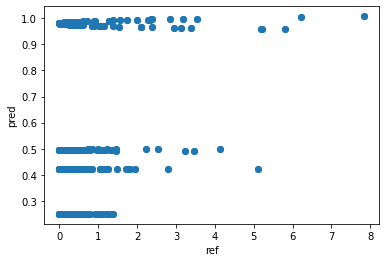

In [47]:
from matplotlib import pyplot as plt
plt.scatter(
    g.nodes['n2'].data['u_ref'].detach(),
    g.nodes['n2'].data['u'].detach()
)

plt.xlabel('ref')
plt.ylabel('pred')